# Kaiser TSNE Visualization

In [1]:
import gpudb
import pandas as pd
import numpy as np

### Read from input table

In [2]:
_db = gpudb.GPUdb(encoding='BINARY', host="127.0.0.1", port="9191")

In [3]:
def table_to_df(_db, _input_table):
    BATCH_SIZE=10000
    _offset = 0
    _table_df = pd.DataFrame()

    while True:
        _response = _db.get_records(table_name=_input_table,
                                    offset=_offset,
                                    limit=BATCH_SIZE)
        
        res_decoded = gpudb.GPUdbRecord.decode_binary_data(
            _response["type_schema"], 
            _response["records_binary"])
        
        _retrieved_records = len(res_decoded)
        _offset += _retrieved_records
        print('Got records: {}/{}'.format(_retrieved_records, _offset))
        
        _table_df = _table_df.append(res_decoded)
        
        if _response['has_more_records'] == False:
            break;
            
    print('Records Retrieved: {}'.format(_table_df.shape))
    _table_df.to_pickle(_input_table + '.pickle')
    return _table_df


We read from the **patient_sv** table containing a 10 dimensional vector for each patient.

In [4]:
_table_df = table_to_df(_db, 'patient_sv')
_table_df.head()

Got records: 10000/10000
Got records: 9092/19092
Records Retrieved: (19092, 11)


,PATIENT_ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,3,-0.026869,0.003544,-0.067632,0.007149,-0.019579,0.012598,0.039725,0.012359,-0.002720,0.005420
1,4,-1.025537,-0.915222,0.135088,0.506937,0.046075,0.790646,-0.736051,-0.174529,-0.203942,-0.047053
2,6,-0.835222,-0.685774,0.319621,-0.053120,-0.135096,-0.106425,0.025238,-0.039275,-0.001030,-0.026680
3,7,-0.465780,-0.495243,0.087060,0.222816,-0.009257,0.530207,-0.575800,-0.017807,-0.002585,0.176052
4,9,-0.065967,0.046649,-0.009301,0.070871,0.131696,0.014793,-0.015506,-0.036466,0.100262,-0.003387


### Calculate K-Means

In [5]:
from sklearn.cluster import KMeans

# convert to numpty matrix
_table_np = _table_df.iloc[:,1:].values.astype(np.float64)
print('Input patient vectors: ', _table_np.shape)

PAT_CLUSTERS = 6
_pat_means = KMeans(n_clusters=PAT_CLUSTERS, 
                    random_state=0).fit(_table_np)
print('K-means clusters: ', _pat_means.cluster_centers_.shape)

Input patient vectors:  (19092, 10)
K-means clusters:  (6, 10)


### Create a combined dataframe of counts and means

In [6]:
# get counts of means
_labels_df = pd.DataFrame(_pat_means.labels_, columns=['idx'])
_counts_df = _labels_df.groupby('idx').size().reset_index(name='count')

# create a combined dataframe
_centroids_df = pd.DataFrame(_pat_means.cluster_centers_, columns=_table_df.columns[1:])
_means_df = pd.concat([_counts_df, _centroids_df], axis=1)
_means_df

,idx,count,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0,17066,-0.027381,0.011948,-0.009277,0.028651,-0.008627,-0.007250,0.005802,0.004578,0.000861,-0.009877
1,1,723,-0.315924,0.372343,0.144270,-0.126296,-0.227225,0.052531,-0.013767,-0.022696,0.004067,-0.010314
2,2,132,-0.597413,0.014181,-1.120111,-0.411596,0.003652,-0.105453,-0.063343,0.010559,-0.006784,0.020970
3,3,815,-0.268761,0.252776,0.054790,0.046236,0.284102,-0.045891,0.039550,0.015015,-0.029403,0.031381
4,4,270,-0.821194,-0.668013,0.263128,-0.066257,-0.018686,-0.083977,0.050015,0.003429,-0.005255,-0.003538
5,5,86,-0.516344,-0.085217,-0.134201,0.605587,0.038393,0.738047,-0.712726,-0.010521,0.009624,0.139909


### Save k-means table to Kinetica

In [7]:
def save_results(df, res_table, schema='KAISERS_SQL'):
    _result_type = [[df.columns[0], gpudb.GPUdbRecordColumn._ColumnType.INT],
                    [df.columns[1], gpudb.GPUdbRecordColumn._ColumnType.INT]]
    
    for _col_name in df.columns[2:]:
        _result_type.append([_col_name, gpudb.GPUdbRecordColumn._ColumnType.DOUBLE])

    _db.clear_table(res_table, options={ 'no_error_if_not_exists':'true' })

    _result_table = gpudb.GPUdbTable(db=_db, _type=_result_type, name=res_table,
        options={'collection_name': schema,
                 'is_replicated': 'true'} )
    
    # Convert to records so we can preserve the array types
    _insert_records = df.to_records(index=False)
    
    # Call item() so the types are converted to python native types
    _insert_rows = [ list(x.item()) for x in _insert_records ]

    print('Inserting rows into <{}>: {}'.format(res_table, len(_insert_rows)))
    _result_table.insert_records(_insert_rows)

In [8]:
save_results(_means_df, 'kmeans_patient')

Inserting rows into <kmeans_patient>: 6


### 2D t-SNE Visualization

t-distributed Stochastic Neighbor Embedding

In [9]:
from sklearn.manifold import TSNE

# This algorithm is slow so we only use the first N points.
TSNE_POINTS = 1000

tsne_2d = TSNE(
    n_components=2, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)

tsne_2d_results = tsne_2d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_2d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.822853
[t-SNE] Error after 1000 iterations: 0.668087
Done (1000, 2)


### Plot labels

The of the t-SNE plot need to be determined manually from the drug ratings for each centriod.

The below SQL will generate a distinct list of TID's and descriptions.

```sql
create or replace table KAISERS_SQL.DRUG_TID as (
    select
        THERAPEUTIC_IDENTIFIER as TID, 
        max(NDC) as TID_NDC,
        max(UPPER(GENERIC_NAME)) as GENERIC_NAME
    from DRUG
    where SRC_NHIN_STORE_ID = 900002841
    group by 1
)
```

The below SQL will generate 4 approximations for a centroid. This should be run for each cluster.

```sql
select top 4
    pv.idx,
    pv.count,
    dv.tid,
    d.generic_name,
    (pv.v0 * dv.v0)
    + (pv.v1 * dv.v1) 
    + (pv.v2 * dv.v2) 
    + (pv.v3 * dv.v3) 
    + (pv.v4 * dv.v4) 
    + (pv.v5 * dv.v5) 
    + (pv.v6 * dv.v6) 
    + (pv.v7 * dv.v7) 
    + (pv.v8 * dv.v8) 
    + (pv.v9 * dv.v9) 
    as drug_rating
from kmeans_patient as pv, drug_sv as dv
join DRUG_TID as d
    ON dv.TID = d.TID
where pv.idx = 0
order by 5 desc;
```

### Manually entered labels for the clusters

(These need to be updated after running on a new data set)

In [10]:
_cbar_labels = [ 
    'Generic "other"',
    'Diabetic + high cholesterol',
    'Tramadol (opiate)',
    'Cholesterol + high blood pressure',
    'Hydrocodone (opiate)',
    'Opiate + muscle relaxant' ]

### Plot t-SNE results with cluster labels

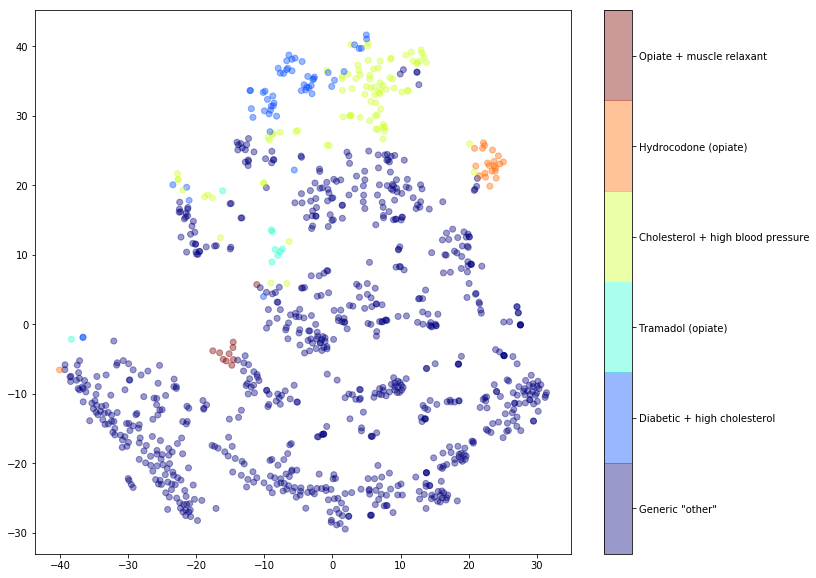

In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,10))
sc = plt.scatter(
    x=tsne_2d_results[:,1],
    y=tsne_2d_results[:,0], 
    c=_pat_means.labels_[:TSNE_POINTS], 
    alpha=0.4, 
    cmap=plt.cm.get_cmap("jet", PAT_CLUSTERS)
)
plt.clim(-0.5, PAT_CLUSTERS - 0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(_cbar_labels)
plt.show()

### 3D t-SNE Visualization

In [12]:
from sklearn.manifold import TSNE
TSNE_3D_POINTS = 2000

tsne_3d = TSNE(
    n_components=3, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)
tsne_3d_results = tsne_3d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_3d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.011383
[t-SNE] Error after 1000 iterations: 0.525896
Done (1000, 3)


In [16]:
import plotly.plotly as py
import plotly.graph_objs as go

scatter_3d = go.Scatter3d(
    x=tsne_3d_results[:,0],
    y=tsne_3d_results[:,1],
    z=tsne_3d_results[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=_pat_means.labels_[:TSNE_3D_POINTS],
        colorscale='Viridis',
        opacity=0.5,
        showscale=True,
        colorbar=dict( 
            ticks='outside'
        )
    )
)

scatter_fig = go.Figure(
    data=[scatter_3d], 
    layout=go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
)

py.iplot(scatter_fig, filename='svd-tsne-3d')